# LightGBM

## Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder


## Dataset

In [10]:
train_df = pd.read_csv('../data/activity_train.csv')
test_df = pd.read_csv('../data/activity_test.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

target_col = "activity"

drop_cols = [target_col]
if 'subject' in train_df.columns:
    drop_cols.append('subject')

X_train = train_df.drop(columns=drop_cols)
y_train_raw = train_df[target_col]

X_test = test_df.drop(columns=drop_cols)
y_test_raw = test_df[target_col]

# 3. Encode Labels (Strings -> Numbers)
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)

# 4. Scale Data (Critical for K-NN, helpful for others)
# This keeps the column names which is important for your Q1 analysis
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
train_cols = list(X_train.columns)
test_cols = list(X_test.columns)
X_test = X_test[train_cols]

Train shape: (7767, 562)
Test shape: (3162, 562)


In [11]:
# Range of depths to test
param_range = [3, 5, 7, 9, 12, 15]

lgbm = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1)

train_scores, test_scores = validation_curve(
    lgbm, 
    X_train_scaled, 
    y_train, 
    param_name="max_depth", 
    param_range=param_range,
    cv=3, 
    scoring="accuracy", 
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

## Plotting

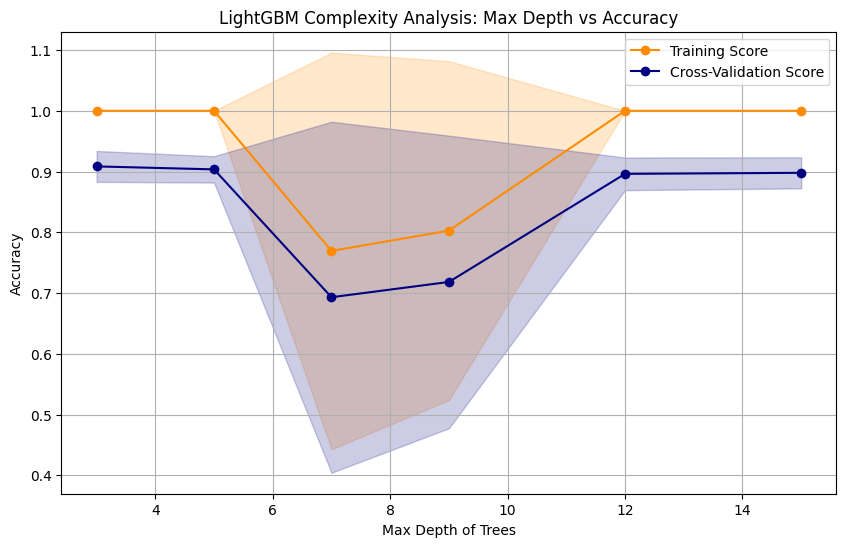

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training Score", color="darkorange", marker='o')
plt.plot(param_range, test_mean, label="Cross-Validation Score", color="navy", marker='o')

# Fill area to show variance (std deviation)
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="darkorange")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color="navy")

plt.title("LightGBM Complexity Analysis: Max Depth vs Accuracy")
plt.xlabel("Max Depth of Trees")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [13]:
models = {}

# --- 1. K-NN ---
print("Training K-NN...")
knn = KNeighborsClassifier()
knn_params = {'n_neighbors': [5, 11, 15, 21], 'weights': ['uniform', 'distance']}
knn_search = RandomizedSearchCV(knn, knn_params, n_iter=5, cv=3, n_jobs=-1, random_state=42)
knn_search.fit(X_train_scaled, y_train)
models['KNN'] = knn_search.best_estimator_

# --- 2. Random Forest (Baseline) ---
print("Training Random Forest...")
rf = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
rf_search = RandomizedSearchCV(rf, rf_params, n_iter=3, cv=3, n_jobs=-1, random_state=42)
rf_search.fit(X_train_scaled, y_train)
models['RF'] = rf_search.best_estimator_

# --- 3. XGBoost ---
print("Training XGBoost...")
xgb = XGBClassifier(eval_metric='mlogloss', tree_method='hist', random_state=42)
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 6, 9]
}
xgb_search = RandomizedSearchCV(xgb, xgb_params, n_iter=5, cv=3, n_jobs=-1, random_state=42)
xgb_search.fit(X_train_scaled, y_train)
models['XGB'] = xgb_search.best_estimator_

# --- 4. LightGBM (The Replacement) ---
print("Training LightGBM...")
lgbm = LGBMClassifier(verbose=-1, random_state=42)
lgbm_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 50], # LightGBM uses leaves, not just depth
    'max_depth': [-1, 10, 20]   # -1 means unlimited
}
# We can afford more iterations (n_iter=10) because LightGBM is fast!
lgbm_search = RandomizedSearchCV(lgbm, lgbm_params, n_iter=10, cv=3, n_jobs=-1, random_state=42)
lgbm_search.fit(X_train_scaled, y_train)
models['LightGBM'] = lgbm_search.best_estimator_

print("\nAll models trained! Test Set Results:")
for name, model in models.items():
    print(f"{name}: {model.score(X_test_scaled, y_test):.4f}")
    if name == 'LightGBM':
        print(f" -> Best LightGBM Params: {lgbm_search.best_params_}")

Training K-NN...
Training Random Forest...
Training XGBoost...
Training LightGBM...

All models trained! Test Set Results:
KNN: 0.8672
RF: 0.9133
XGB: 0.9254
LightGBM: 0.9228
 -> Best LightGBM Params: {'num_leaves': 31, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1}
